In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Mini-batch size
mb_size = 64
transform = transforms.ToTensor()
traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=mb_size)

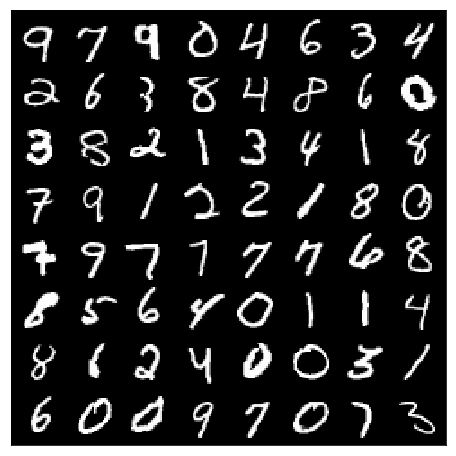

torch.Size([64, 1, 28, 28])


In [3]:
dataiter = iter(trainloader)
imgs, labels = dataiter.next()

def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy() # transfoming tensors to numpy arrays
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

print(imgs.size())
imshow(imgs)

In [4]:
# Defining the parematers of the network
h_dim = 128    # number of hidden neurons in our hidden layer
Z_dim = 100    # dimension of the input noise for generator
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1)
print(X_dim)

784


In [5]:
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [6]:
# Defining the Genrator 

class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)
    
test = Gen()
print(test)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [7]:
# Defining the Discriminator

class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)
    
test = Dis()
print(test)

Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [8]:
# Instantiating the networks
G = Gen()
D = Dis()

In [9]:
# Defining solver to do the mini batch stochastic gradient descent 
# one for each network 
G_solver = opt.Adam(G.parameters(), lr = lr)
D_solver = opt.Adam(D.parameters(), lr = lr)

Epoch:0, G_loss:6.040977713395792, D_loss:0.06529558495730599


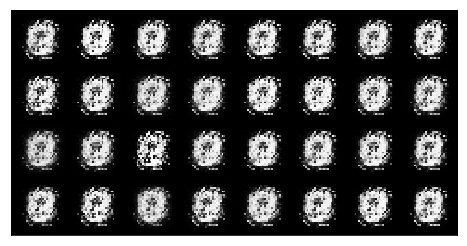

Epoch:1, G_loss:5.042467108413355, D_loss:0.06841862188386065


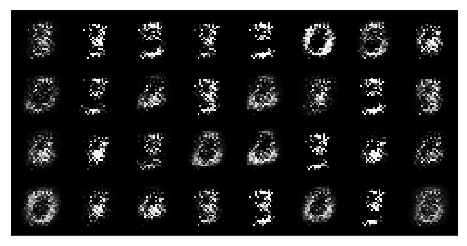

Epoch:2, G_loss:4.465577314911621, D_loss:0.11095431790367435


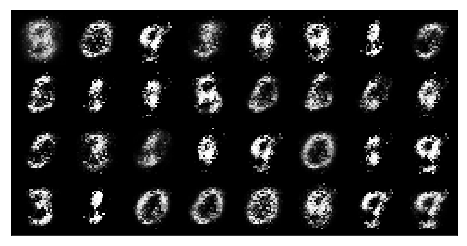

Epoch:3, G_loss:4.905230783704502, D_loss:0.22258221656719504


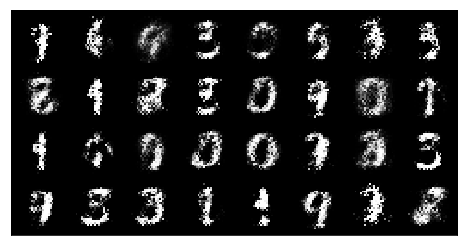

Epoch:4, G_loss:4.264242522752107, D_loss:0.3150952695878838


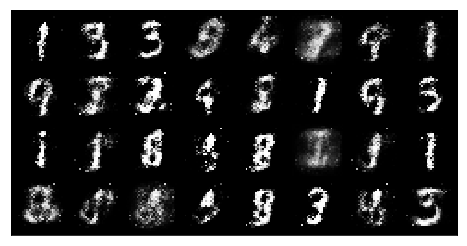

Epoch:5, G_loss:3.6127661494558048, D_loss:0.4450157148116179


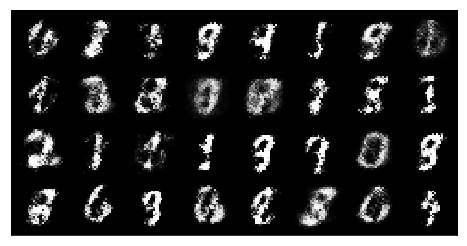

Epoch:6, G_loss:3.1420448609252474, D_loss:0.5490655687921591


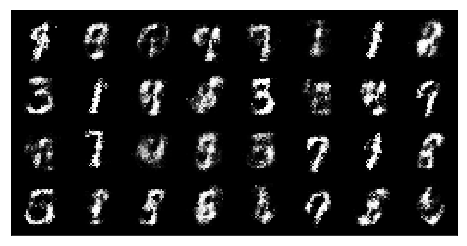

Epoch:7, G_loss:2.939555989272559, D_loss:0.6181900711583176


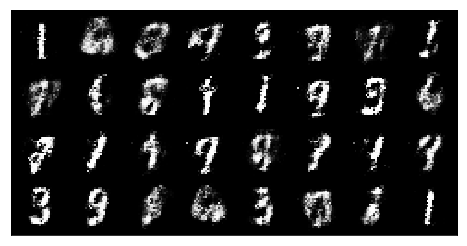

Epoch:8, G_loss:2.886390478626243, D_loss:0.6703928682659226


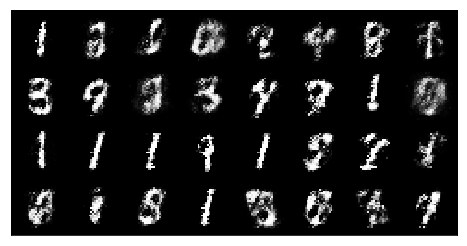

Epoch:9, G_loss:2.8473124943816583, D_loss:0.712810954813764


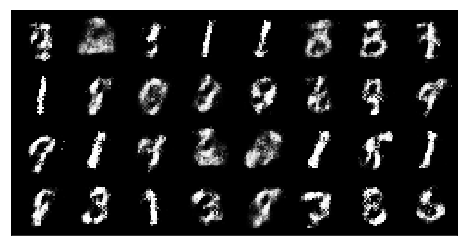

Epoch:10, G_loss:2.4015345392959206, D_loss:0.8435051679166395


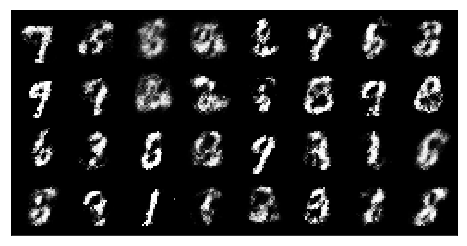

Epoch:11, G_loss:2.201177199639237, D_loss:0.8851739916720116


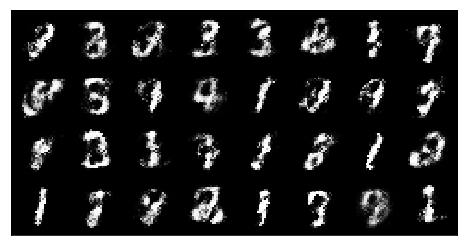

Epoch:12, G_loss:2.1906684170653827, D_loss:0.8910494752720729


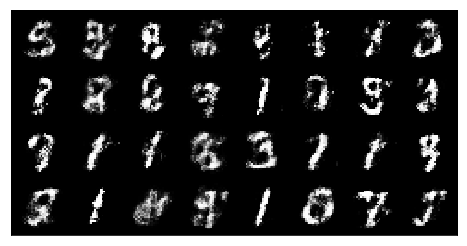

Epoch:13, G_loss:2.0773837370658987, D_loss:0.8839574109262495


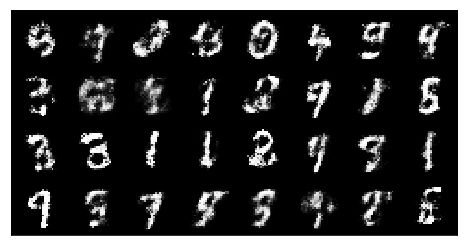

Epoch:14, G_loss:2.0278365038859563, D_loss:0.9012976627487109


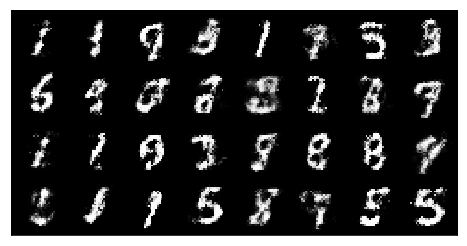

Epoch:15, G_loss:1.9077693760267962, D_loss:0.886663865814331


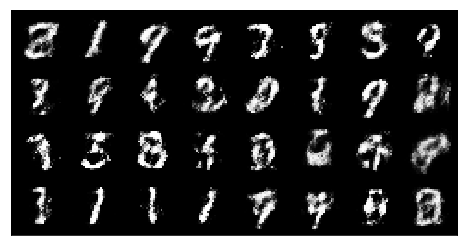

Epoch:16, G_loss:1.8552175677661449, D_loss:0.8894629764404378


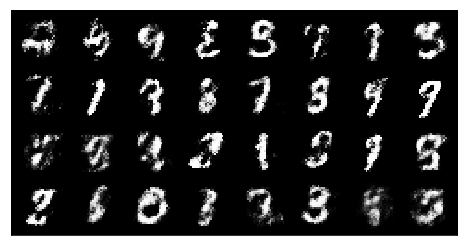

Epoch:17, G_loss:1.8646663382871826, D_loss:0.8751338652011428


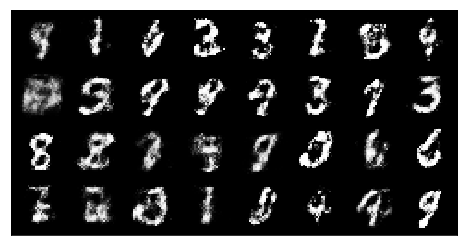

Epoch:18, G_loss:1.851786426135472, D_loss:0.8674940469422574


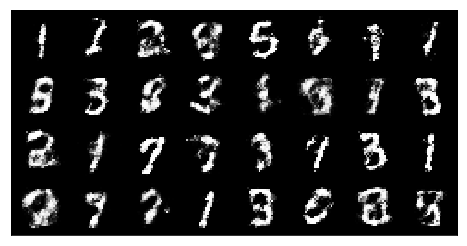

Epoch:19, G_loss:1.8121912639532516, D_loss:0.8771327533193235


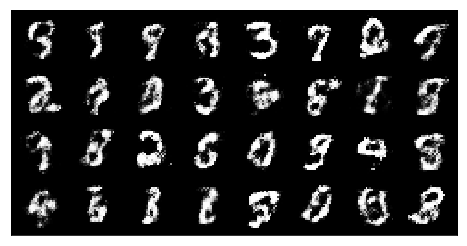

In [10]:
# Defining the training for loop
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(trainloader):
        X, _ = data
        X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(mb_size, 1)
        zero_labels = torch.zeros(mb_size, 1)
        
        # Random normal distribution for each image
        z = torch.randn(mb_size, Z_dim)
        
        
        # Feed forward in discriminator both 
        # fake and real images
        D_real = D(X)
        # fakes = G(z)
        D_fake = D(G(z))
        
        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, Z_dim)
        D_fake = D(G(z))
        
        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{}, G_loss:{}, D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)
        
        